---
title: Optimal Decision Making
author: Julia Joy
date: '2024-03-31'
image: "image.jpg"
description: "Blog Post 5"
---

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

/var/folders/6v/npbkg9_919s0m2j5qd702gf00000gn/T/ipykernel_10000/516695261.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


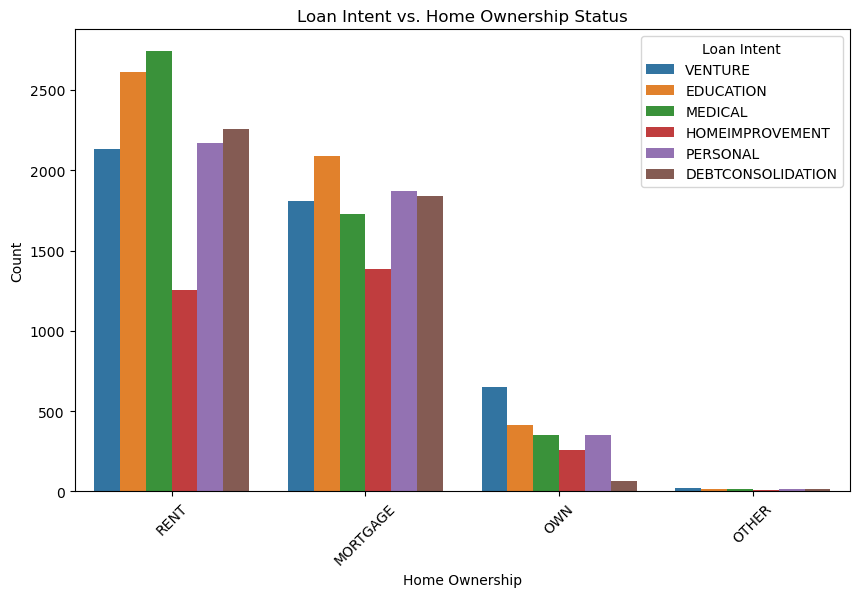

In [2]:
#PART B Visualizations 

import seaborn as sns
import matplotlib.pyplot as plt

#figure 1 
plt.figure(figsize=(10, 6))
sns.countplot(x='person_home_ownership', hue='loan_intent', data=df_train)
plt.title('Loan Intent vs. Home Ownership Status')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Loan Intent')
plt.show()

/var/folders/6v/npbkg9_919s0m2j5qd702gf00000gn/T/ipykernel_10000/3508508793.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  IR = df_train.groupby(['ageCategory']).agg({'loan_int_rate': 'mean'}).reset_index()


  ageCategory  loan_int_rate
0    (20, 30]      10.997363
1    (30, 40]      11.053365
2    (40, 50]      11.021150
3    (50, 60]      11.054049
4    (60, 70]      11.019730
5    (70, 80]       9.636000
6    (80, 90]       7.510000
7   (90, 100]            NaN


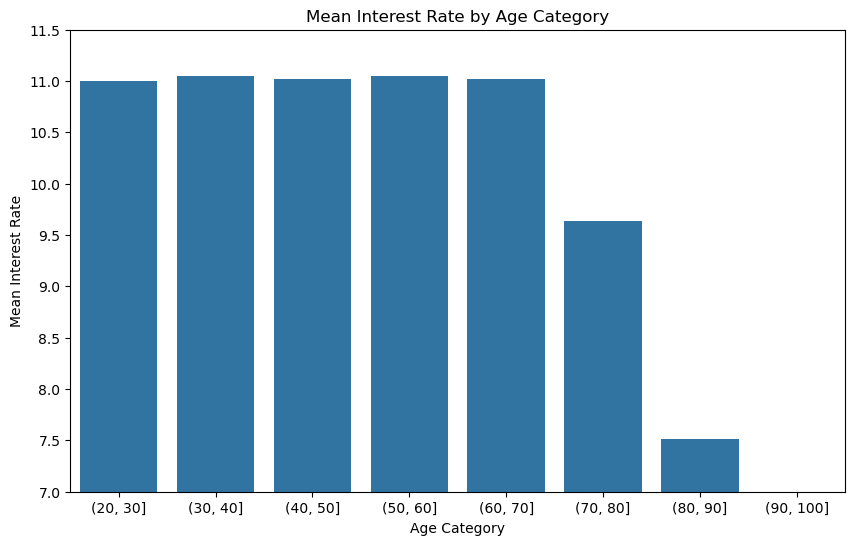

In [5]:
#figure 2
ageCategory = [20, 30, 40, 50, 60, 70, 80, 90, 100]
df_train['ageCategory'] = pd.cut(df_train['person_age'], bins=ageCategory)
IR = df_train.groupby(['ageCategory']).agg({'loan_int_rate': 'mean'}).reset_index()
IR = IR.sort_values(by='ageCategory', ascending=True)
print(IR)

plt.figure(figsize=(10, 6))
sns.barplot(x='ageCategory', y='loan_int_rate', data=IR)
plt.title('Mean Interest Rate by Age Category')
plt.xlabel('Age Category')
plt.ylabel('Mean Interest Rate')
plt.ylim(7, 11.5) 
plt.show()

In [6]:
#summary table
dfIRSorted = df_train.dropna(subset=['loan_int_rate'])
dfIRSorted = df_train.sort_values(by='loan_int_rate', ascending=True)

lowest10IR = dfIRSorted[['ageCategory', 'person_home_ownership', 'loan_int_rate']]
lowest10IR = lowest10IR.head(10).drop_duplicates()

print(lowest10IR)

      ageCategory person_home_ownership  loan_int_rate
6061     (20, 30]              MORTGAGE           5.42
24160    (30, 40]              MORTGAGE           5.42
15162    (20, 30]                  RENT           5.42
6383     (20, 30]                   OWN           5.42
21672    (30, 40]                  RENT           5.42


In [7]:
###PART C 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

cleanedData = df_train.dropna()
featureCombos = [
    ['loan_int_rate', 'loan_percent_income'], 
    ['person_age', 'person_income', 'person_emp_length', 'loan_amnt'],
    ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income']
]

for features in featureCombos:
    X = cleanedData[features]
    y = cleanedData['loan_status'] 

    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)

    y_pred = model.predict(X)
    #print(classification_report(y_test, y_pred))
    coef = model.coef_
    print(coef)

    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print("Cross-validation scores:", scores)

[[0.28951836 8.41878466]]
Cross-validation scores: [0.82572614 0.82354226 0.82922035 0.81476627 0.82350371]
[[ 2.26769069e-03 -3.25488772e-05 -3.34182406e-02  1.15567329e-04]]
Cross-validation scores: [0.79537017 0.80061149 0.80082988 0.79663609 0.79750983]
[[-8.69205819e-04 -1.19666596e-06 -2.07101202e-02 -7.94597482e-05
   3.13264706e-01  1.09583696e+01]]
Cross-validation scores: [0.83751911 0.83380651 0.83358812 0.82459589 0.83355177]


In [8]:
import numpy as np 

probs = model.predict_proba(X)[:, 1]
thresholds = np.linspace(0, 1, 100)
potentialAvgProfits = []

for threshold in thresholds:
    predictions = probs >= threshold
    profitPer = np.where(predictions == 1,
                                   X['loan_amnt'] * (1 + 0.25 * X['loan_int_rate']) ** 10 - X['loan_amnt'],
                                   X['loan_amnt'] * (1 + 0.25 * X['loan_int_rate']) ** 3 - 1.7 * X['loan_amnt'])
    
    avgProfit = profitPer.mean()
    potentialAvgProfits.append(avgProfit)


threshIndex = np.argmax(potentialAvgProfits)
bestThresh = thresholds[threshIndex]
bestAvgProfit = potentialAvgProfits[threshIndex]
print(bestThresh)
print(bestAvgProfit)

0.0
31508209740.26809


In [9]:
#load test set 

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

In [10]:
cleanedTestData = df_test.dropna()
X_test = cleanedTestData[features]

probs = model.predict_proba(X_test)[:, 1]

for threshold in thresholds:
    predictions = probs >= threshold
    profitPer = np.where(predictions == 1,
                                   X_test['loan_amnt'] * (1 + 0.25 * X_test['loan_int_rate']) ** 10 - X_test['loan_amnt'],
                                   X_test['loan_amnt'] * (1 + 0.25 * X_test['loan_int_rate']) ** 3 - 1.7 * X_test['loan_amnt'])
    
    avgProfit = profitPer.mean()
print(avgProfit)

611638.5685903775


In [ ]:
#Part F 

#SHOULD FIRST ADD IN THE RESULTS OF MY MODEL INTO A NEW TEST DATA SET, evaluateModelData

#Is it more difficult for people in certain age groups to access credit under your proposed system?
ageCategory = pd.cut(df_test['person_age'], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100])
ageCatCounts = df_test.groupby(ageCategory)['loan_status'].count()
ageCatApproved = df_test.groupby(ageCategory)['loan_status'].mean()

#Is it more difficult for people to get loans in order to pay for medical expenses? How does this compare with the actual rate of default in that group? What about people seeking loans for business ventures or education?
approvalsByLI = df_test.groupby('loan_intent')['NEWCOLUMN'].mean() 
defaultRates = df_test.groupby('loan_intent')['NEWCOLUMN'].mean()


#How does a person’s income level impact the ease with which they can access credit under your decision system?
incomeCategory = pd.cut(df_test['person_income'], bins=[0, 50000, 100000, 150000, 200000, np.inf])
approvalsbyInc = df_test.groupby(incomeCategory)['NEWCOLUMN'].mean()  # Proportion of approvals by income level

## Part G 

Considering that people seeking loans for medical expense have high rates of default, is it fair that it is more difficult for them to obtain access to credit?

You are free to define “fairness” in a way that makes sense to you, but please write down your definition as part of your discussion.

## Conclusion 